# Dynamic Programming Tracker for Hands
Implementation of  [Dreuw06 - Tracking Using Dynamic Programming
for Appearance-Based Sign Language Recognition](http://thomas.deselaers.de/publications/papers/dreuw_fg06.pdf)

## Imports

In [2]:
import os
import numpy as np
import skimage.io
import skimage
from scipy import ndimage
from skimage.draw import circle_perimeter_aa,circle
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as anim

from scipy.stats import multivariate_normal

import skvideo.io
import skvideo.datasets

import itertools



## Misc utility stuff

In [3]:
def video_rgb_to_hsv(video):
  T=video.shape[0]
  for t in range(T):
    video[t,:,:,:]=matplotlib.colors.rgb_to_hsv(video[t,:]/255)


def video_hsv_to_rgb(video):
  T=video.shape[0]
  for t in range(T):
    video[t,:,:,:]=matplotlib.colors.hsv_to_rgb(video[t,:])*255


## Configuration


In [4]:
test_path='test_data/All_Blacks.5846.main_glosses.mb.r480x360.mp4'
output_path='tmp/output/'
filename =os.path.basename(test_path)
tracked_video_path= os.path.join(output_path,filename)
debug_video_path=os.path.join(output_path,"_debug".join(os.path.splitext(filename)))
data = skvideo.io.ffprobe(test_path)['video']
rate = data['@r_frame_rate']

video = skvideo.io.vread(test_path).astype(float)

print("Original video shape: %s" % str(video.shape))
video=video[0::1,:,:,:]
video_rgb_to_hsv(video)

T,h,w,c=video.shape


Original video shape: (54, 368, 480, 3)


## Local  Score

### Jump penalty functions
* p-norm between coordinates: $d(x_1,x_2)=||x_1-x_2||^p$

### Skin pixel scores
* Gaussian model

### Movement scores
* p-norm between frames

In [5]:
def jump_penalty_euclidean(p1,p2):
  d=p1-p2
  return np.sum(d**2)

def skin_pixel_scorer(video):
  T,h,w,c=video.shape
  score=np.zeros((T,h,w))
  mu_hsv=np.array([20.0,35.0,73.0])/255.0
  mu_rgb=np.array([176,134,112])
  cov=np.array([0.3,0.5,10])
  mu=mu_hsv

  for t in range(T):
    score[t,:,:]= multivariate_normal.pdf(video[t,:,:,:],mu,cov)
  
  mean=score.mean()
  std=score.std()
  threshold = mean + 0.2*std
  print("Pixel score treshold: %f" % threshold)
  score[score<threshold]=0
  score=ndimage.grey_erosion(score,(1, 10, 10))
  #score= ndimage.gaussian_filter(score, sigma=(0,3,3), order=0)
  return score

def euclidean_movement_score(video):
  T,h,w,c=video.shape
  score=np.zeros((T,h,w))
  
  delta=np.diff(video,n=1,axis=0)
  delta=np.square(delta)
  delta=np.sqrt(np.sum(delta,axis=3))
  print(delta.shape)
  score[1:,:,:]=delta
    
#   for t in range(T-1):
#     delta=np.square(video[t+1,:,:,:]-video[t,:,:,:])
#     score[t,:,:]= np.sqrt(np.sum(delta,axis=2))
    # if (t % 5==0):
    #   plt.clf()
    #   plt.imshow(score[t,:,:])
    #   plt.colorbar()
    #   plt.pause(0.1*1.0/60.0)
  mean=score.mean()
  std=score.std()
  threshold = mean - 0.1*  std
  print("Movement score treshold: %f" % threshold)
  score[score<threshold]=0
  score=ndimage.grey_erosion(score,(1, 20, 20))
  score= ndimage.gaussian_filter(score, sigma=(0,3,3), order=0)
  return score

def manhattan_movement_score(video):
  T,h,w,c=video.shape
  score=np.zeros((T,h,w))
  
  delta=np.diff(video,n=1,axis=0)
  delta=np.abs(delta)
  delta=np.sum(delta,axis=3)
  print(delta.shape)
  score[1:,:,:]=delta
    
  mean=score.mean()
  std=score.std()
  threshold = mean - 0.1*  std
  print("Movement score treshold: %f" % threshold)
  score[score<threshold]=0
  score=ndimage.grey_erosion(score,(1, 20, 20))
  score= ndimage.gaussian_filter(score, sigma=(0,3,3), order=0)
  return score

def calculate_local_score(video,scorers,weights):
    
    score=scorers[0](video)*weights[0]
    local_score=score
    scores=[score]
    for i in range(1,len(scorers)):
        score=scorers[i](video)*weights[i]
        local_score=local_score+score
        scores.append(score)
    return local_score,scores

movement_weight=0.7
scorers=[manhattan_movement_score,skin_pixel_scorer]
scorers_labels=['manhattan_movement','pixel']
scorers_weights=[movement_weight,1-movement_weight]
local_score,scores=calculate_local_score(video,scorers,scorers_weights)

(53, 368, 480)
Movement score treshold: 0.016295
Pixel score treshold: 0.024963


## Test model

In [6]:
class DPTracker:  

  def __init__(self,neighbourhood_size):
    self.neighbourhood_size=neighbourhood_size

  def backtrack_path(self,backtracking_path,score):
    Tm,h,w,dim_indices=backtracking_path.shape
    T=Tm+1
    path=np.zeros((T,2),dtype=int) # 2 => (x,y)
    best_index_last_frame = np.argmax(score[-1,:,:])
    x,y= np.unravel_index(best_index_last_frame , score[-1,:,:].shape)
    path[-1,:]=np.array([x,y])
    for t in reversed(range(T-1)):
      x,y= tuple(path[t+1,:])
      path[t, :] = backtracking_path[t,x,y,:]
    return path
        
  def track(self,video,local_score,jump_penalty,jump_penalty_weight):
    video = ndimage.gaussian_filter(video, sigma=(0, 2, 2, 0), order=0)
    T,h,w,c=video.shape
    self.backtracking_path=np.zeros((T-1,h,w,2),dtype=int) # 2 => (x,y) for T-1
    self.score=np.zeros((T,h,w))
    n=self.neighbourhood_size
    n2=n+1
    self.jump_penalty_matrix=jump_penalty_weight*self.generate_jump_penalty_matrix(jump_penalty,n)

    self.score[0,:,:]=local_score[0,:,:]
    self.local_score =local_score
        
    initial_values=np.zeros((h,w,2))

    for i in range(h):
      for j in range(w):
        initial_values[i,j,:]=np.array([i,j])
    self.backtracking_path[:,:,:,:]=initial_values
    
    print("Calculating score for frame:")
    for t in range(1,T):
      print("%d/%d - " % (t,T-1), end="")
      for i in range(n, h-n):
        for j in range(n, w-n):
          neighbourhood_score=self.score[t-1,i-n:i+n2,j-n:j+n2]
          previous_score=neighbourhood_score-self.jump_penalty_matrix
            
          index=np.argmax(previous_score)
          best_score=previous_score.flat[index]
          relative_x,relative_y=np.unravel_index(index, self.jump_penalty_matrix.shape)
          x = i + relative_x - n
          y = j + relative_y - n
          self.backtracking_path[t-1, i, j, 0] =x
          self.backtracking_path[t-1, i, j, 1] =y
          self.score[t,i,j]=self.local_score[t,i,j]+best_score #np.mean(previous_score)
    self.path=self.backtrack_path(self.backtracking_path,self.score)
    
    return self.path

  def generate_jump_penalty_matrix(self, jump_penalty, neighbourhood):
    n=neighbourhood*2+1
    matrix=np.zeros((n,n))
    center=np.array([neighbourhood,neighbourhood])
    for i in range(n):
      for j in range(n):
        position=np.array([i,j])
        matrix[i,j]=jump_penalty(center,position)
    return matrix


neighbourhood_size=30
jump_penalty_weight=0.0005
tracker=DPTracker(neighbourhood_size)
track_result=tracker.track(video,local_score,jump_penalty_euclidean,jump_penalty_weight)

print("Tracking coordinates")
print(track_result.T)


Calculating score for frame:
1/53 - 2/53 - 3/53 - 4/53 - 5/53 - 6/53 - 7/53 - 8/53 - 9/53 - 10/53 - 11/53 - 12/53 - 13/53 - 14/53 - 15/53 - 16/53 - 17/53 - 18/53 - 19/53 - 20/53 - 21/53 - 22/53 - 23/53 - 24/53 - 25/53 - 26/53 - 27/53 - 28/53 - 29/53 - 30/53 - 31/53 - 32/53 - 33/53 - 34/53 - 35/53 - 36/53 - 37/53 - 38/53 - 39/53 - 40/53 - 41/53 - 42/53 - 43/53 - 44/53 - 45/53 - 46/53 - 47/53 - 48/53 - 49/53 - 50/53 - 51/53 - 52/53 - 53/53 - Tracking coordinates
[[315 315 315 315 315 315 292 300 287 284 284 284 284 283 282 281 280 279
  278 277 276 275 274 273 272 271 270 269 268 267 266 265 264 263 262 261
  260 259 258 257 264 281 293 282 300 320 337 337 337 337 337 337 337 337]
 [219 219 219 219 219 219 228 229 225 226 228 230 232 233 233 233 233 233
  233 233 233 233 233 233 233 233 233 233 232 232 232 232 232 232 232 232
  232 231 231 231 232 231 229 226 223 214 209 209 209 209 209 209 209 209]]


## Save output

In [7]:

def draw_tracked(video,track_result):
  T,h,w,c = video.shape
  image_shape=(h,w)
  radius=5
  color=np.array([255.0,0,0])
  for t in range(T):
    x,y=tuple(track_result[t,:])
    if (x-radius>=0) and (x+radius<h) and (y-radius>=0) and (y+radius<w):
      rr,cc=circle(x,y,radius,shape=image_shape)
      video[t,rr,cc,:]=color
  return video


def generate_debug_video(video,scores,labels,output_path):
#   FFMpegWriter= anim.writers['ffmpeg']
  metadata=dict(title="Output")
#   writer=FFMpegWriter(fps=6,bitrate=16384*2,metadata=metadata)

  columns=int(np.ceil(len(scores)/2))+1
  f,axes=plt.subplots(2,columns,dpi=100)
  axes =list(itertools.chain.from_iterable(axes))
  image_ax=axes[0]
  f.set_size_inches(10,10, True)
  T,h,w,c=video.shape
  base_file,ext=os.path.splitext(output_path)
#   with writer.saving(f,debug_video_path,T):
  cbars=[]
  ranges=[]
  for s in range(len(scores)):
    ranges.append( (0,np.max(scores[s])) )
  for t in range(T):
    plt.suptitle("Frame %d/%d" % (t,T-1))
    image_ax.cla()
    plot=image_ax.imshow(video[t,:,:,:])
    
    for s in range(len(scores)):
      ax=axes[s+1]
      ax.cla()
      ax.set_title(labels[s],fontsize=10)
    
      data=scores[s][t,:,:]
      vmin,vmax=ranges[s]
      plot=ax.imshow(data,cmap='gray',vmin=vmin,vmax=vmax)  
      if t==0:
        cbar=f.colorbar(plot, ax=ax)
        cbar.ax.tick_params(labelsize=10)
        cbar_ticks = np.linspace(vmin,vmax, num=10, endpoint=True)
        cbar.set_ticks(cbar_ticks)
        cbars.append(cbar)
#       plot.set_clim([data.min(), data.max()])
#       cbar_ticks = np.linspace(data.min(), data.max(), num=10, endpoint=True)
#       cbars[s].set_ticks(cbar_ticks) 
#       plot.autoscale()
    a='%s_%03d.png' % (base_file,t)
    plt.savefig(a)
#       writer.grab_frame()

tracked_video=np.copy(video)
video_hsv_to_rgb(tracked_video)
tracked_video=draw_tracked(tracked_video,track_result)
tracked_video=tracked_video.astype('short')
show_scores=[local_score,tracker.score]+scores
show_scores_label=['local','global']+scorers_labels
generate_debug_video(tracked_video, show_scores,show_scores_label,debug_video_path)

# skvideo.io.vwrite(tracked_video_path, tracked_video, outputdict={
#   '-vcodec': 'libx264',
#   '-pix_fmt': 'yuv420p',
#   '-r': rate,
# })
plt.close("all")

(54,)


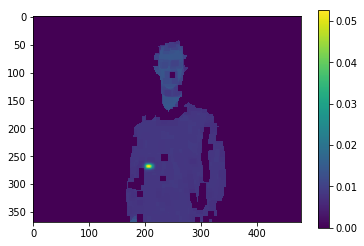

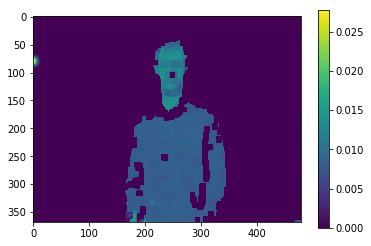

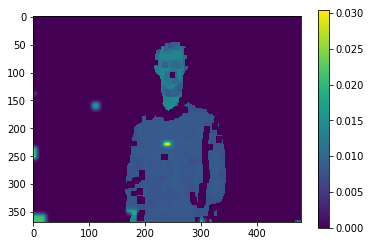

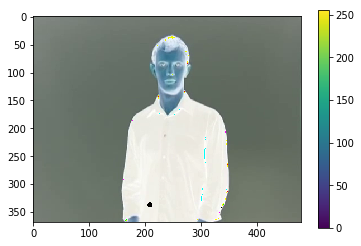

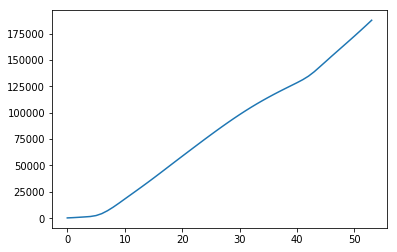

In [8]:
score=tracker.local_score
plt.imshow(score[T-2,:,:])
plt.colorbar()
plt.figure()
plt.imshow(score[T-3,:,:])
plt.colorbar()
plt.figure()
plt.imshow(score[T-4,:,:])
plt.colorbar()
plt.figure()
plt.imshow(tracked_video[T-1,:,:,:])
plt.colorbar()
plt.figure()
mean_scores=np.sum(tracker.score,axis=(1,2))
print(mean_scores.shape)
plt.plot(mean_scores)
plt.show()
